## Transfer Learning ##

We are already done with trying to build a couple of different models from basic linear to convolutional models. However, for the majority of the models that we've been making, they've all resulted with poor performances on their prediction power.

So, it begs the question - **are there already well-performing models that exist which we can use to solve our problems?**

The answer is a big YES!

**What is Transfer Learning?**

**Transfer Learning** is the process of taking existing patterns (weights) from another model has learned from a different problem which we can also use for our own problem. 

An example of this would be to take the patterns from a computer vision model that has learned from other datasets such as *ImageNet* - which is a dataset composed of millions of different object images and then use these patterns to power our own model, in our case that would be the FoodVision Mini model that we tried making in the previous chapter. 

You could also do this for models that focus on Natural Language Processing. You can take the learned patterns from a language model that has gone through large amounts of text representing a certain to language and from there use that as a basis for your model to classify different text samples.

The core concept is simple - take well-performing existing models and apply their patterns to your own problem.

![Display](images/07-transfer-learning-example-overview.png)

**Why Use Transfer Learning?**

There are two major reasons why transfer learning is beneficial:

1. You can use an already existing model proven to work on a set of problems that are similiar to yours.

2. You can use the *learned patterns* from similiar data to your own data. This tends to result in a high predictive power when working with less custom data.

![Display](images/07-transfer-learning-for-foodvision-mini.png)

Professionals have been utilizing transfer learning in practice and this has also been used for research purposes. Overall, it's a well accepted method for improving the predictive power of models. 

Jeremy Howard who is the founder of *fast.ai* and is one of the bigger names in the machine learning world is a big proponent for transfer learning. In his own words -

*'The things that really make a difference (transfer learning), if we can do better at transfer learning, it’s this world changing thing. Suddenly lots more people can do world-class work with less resources and less data. — Jeremy Howard on the Lex Fridman Podcast'*

**Where To Get Pretrained Models?**

Luckily for you, deep learning is a very open field. Many scholars and professionals share theor work which in turn makes things a lot more accessible for those that have less resources and data to work with.

Code and pretrained models from the latest state-of-the-art research is released to the public within a few days after publishing. In addition, you can have easy access to these pretrained models from many different platforms which in turn you can use for your own problems.

Let's take a look at a few of these places to get from:

* **PyTorch Domain Libraries** - Each of the PyTorch domains (torchvision, torchtext) come with pretrained models.

* **HuggingFace Hub** - Series of pretrained models on different domains - vision, text, audio, and more. These models come from a range of organizations around the world. Not to mention that there are also many datasets available to use.

* **timm - PyTorch Image Models Library** - This is a collection of all PyTorch computer voision models in addition to other computer vision features that you can use to your benefit.

* **paperswithcode** - Colllection of the latest state-of-the-art machine learning papers in addition to code implementations of these research papers. You can also see benchmarks of different models 

![Display](images/07-transfer-learning-where-to-find-pretrained-models.png)

**Topics To Cover**

1. *Setting Up* - Since we've already written the code that we need to work with models, we'll just download them and use them again.

2. *Getting Data* - We'll be using the same dataset as before - the pizza, steak, and sushi image classification dataset since we're looking to improve the model's results on this problem.

3. *Creating Datasets & DataLoaders* - We've made *data_setup.py* which was a script that we used to make Datasets and DataLoader's and we'll still use them here

4. *Get + Customize Pretrained Model* - Choose a pretrained model and download from *torchvision.models* then customize that to address our own problem.

5. *Train Model* - Test how the pretrained model works on our dataset. We'll still use the same functions for training in the previous chapter.

6. *Evaluate Model Through Plotting Loss Curves* - We'll check the loss curves and see if the model is overfitting or underfitting.

7. *Make Predictions* - We'll grab images from the test set and make predictions on them. It's good to see the evaluation metrics and all but it's another to visualize the actual work and results being done. 

**Setting Up**

As from before, we start with importing/downloading the required modules. We've already made some of the scripts before that we need to train a model so it's good practice to leverage those now. Specifically, we're going to use *data_setup.py*  and *engine.py*. We will also grab the *torchinfo* package so that we can see more in-depth view of the model. 

In [26]:
import torch
import torchvision
import random

from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision import models
from scripts import data_setup
from scripts import engine
from scripts import helper_functions
from torchinfo import summary
from timeit import default_timer as timer
from pathlib import Path
from PIL import Image
from typing import List, Tuple
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

/// Manually Copied Files From 06 - 07 ///

Let's setup the directory paths for the datasets.

In [3]:
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

train_dir = image_path/"train"
test_dir = image_path/"test"

**Creating Datasets & DataLoaders**

We'll import the modules from *data_setup* to make the Datasets and DataLoaders but before we are able to work with those functions, we'll have to address something very important first. Since we're dealing with a pretrained model from *torchvision.models*, we'll need a specific transform to prepare the images that we have because right now, it won't work. 

**Creating Transform For Pretrained Model - Manual Creation**

When it comes to dealing with pretrained models, it's important to always make sure the custom data going into the model is compatible and prepared the same way that the original training data went through the model. Everything has to be the same. You can't fit a square in a triangle hole.

Let's list down the transforms that we're going to need to use:

1. Mini-batches of size [batch_size, color_channels, height, width] of which height and width are at least 224x224. | Code to use are *torch.vision.transforms.Resize((224,224))* for resizing images and *torch.utils.data.DataLoader()* for creating batches

2. We need to make the images into values between 0 & 1. | Code to use is *torchvision.transforms.ToTensor()*

3. For the third step, we'll need to get the mean of [0.485, 0.456, 0.406] - this is the values across each color channel. | Code to use is torchvision.transforms.Normalize(mean=...) to adjust the mean of the images.

4. Lastly, we'll set a standard deviation of [0.299, 0.224, 0.225]. These are the values across each colour channel similiar to the previous step. | Code to use is *torchvision.transforms.Normalize(std=...)* to adjust the standard deviation of the images

It's important to note that different pretrained models have different input requirements. So in the pretrained model that we're going to use, it's size is [3,224,224] but for others it might be [3,240,240] and etc. Just check the documentation to see what sizes they take. 

You might be wondering what's the purpose of the mean and standard deviation? Those come from the data itself. They were calculated from the ImageNet dataset by taking the mean and standard deviation from a subset of images.

More importantly, *we don't actually need to do these two*. Neural networks are inherently capable of figuring out the appropriate data distributions meaning that they'll calculate the mean and standard deviations on their own. But adding them manually at the start can help the network achieve better performances quicker since they won't have to calculate these two anymore.

With that said, let's make the *transforms* that can make our data compatible to our pretrained model.

In [4]:
manual_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.299, 0.224, 0.225]),
])

manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.299, 0.224, 0.225])
)

We've manually created a series of transforms to prep our data meaning that we can now switch to setting up our Datasets and DataLoaders. Let's use the same function from *data_setup.py* in making them. 

In [5]:
train_dataloader, test_dataloader, class_list = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=32,
    num_workers=0)

train_dataloader, test_dataloader, class_list

(<torch.utils.data.dataloader.DataLoader at 0x1bca2dc9820>,
 ['pizza', 'steak', 'sushi'])

Remember that we were working with a manual implementation of the transforms for the pretrained model. You might encounter this style with other resources so it's best to just be aware of this type of technique. 

Not only that but the fact that this transform is manually created means that there are infinite possibilities to work with. You can include data augmentation techniques to the transform pipleline if you think that would help. 

**Creating Transform For Pretrainde Model - Auto Creation**

You don't necessarily have to make the transforms manually by yourself. PyTorch includes an automatic transform creation feature. 

Whenever you setup a model from *torchvision.models* and then select a pretrained model's weights you'd like to use, the code would look like this:

*weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT*

 Unpacking this for a bit:

* *EfficientNet_B0_Weights* is the model architecture weights that we'd like to grab and there are many different architecture to use.

* *DEFAULT* means that you just grab the best available weights - the best performing one's for ImageNet - You can specify different options such as *IMAGENET_V1* or *IMAGENET_V2* and usually the higher version means the better but if you want to always grab the latest one then *DEFAULT* should be the norm.

Let's put this into code.

In [6]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

Once we have the weights of the model, we can access the transforms() method which will give us the data transforms that were used to train *EfficientNet_B0_Weights* on ImageNet. 

In [7]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

See how *auto_transforms* is very similiar to *manual_transforms* with some slight differences but for the most part, they still work the same. It's just that *auto_transforms* came directly from the model architecture that we picked meanwhile *manual_transforms* is something that we had to make from scratch.

You can see that with using this method of just grabbing the transforms directly from the weights of the pretrained model with *weights.transforms()*, you're already ensuring that you're using the same data transforms as it used when it was training.

But of course, you lose the customization options with this method. Let's try making the Datasets and DataLoaders again but this time, we'll use the *auto_transforms*

In [8]:
train_dataloader, test_dataloader, class_list = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32,
    num_workers=0)

train_dataloader, test_dataloader, class_list

(<torch.utils.data.dataloader.DataLoader at 0x1bca2e04710>,
 ['pizza', 'steak', 'sushi'])

**Getting Pretrained Models**

We're done with making our data ready so it's time to actually work with a pretrained model. We've been building neural networks before from scratch and while that's a really good way to get the grasp of neural networks, it's not really efficient if you want to make a model that is actually giving good results

That's why we're working with *Transfer Learning* since the main idea - again is to **take good performing models that is similiar to our problem and then customize that to suit our own case**.

Because we are working with a computer vision problem, we'll find a pretrained classification model in *torchvision.models*

Take a look at the different architectures available and look around.

You'll see examples such as:

* **ResNet** - *torchvision.models.resnet18()* | *torchvision.models.resnet50()*
* **VGG** - *torchvision.models.vgg16()*
* **EfficientNet** - *torchvision.models.efficientnet_b0()*
* **VisionTransformer** - *torchvision.models.vit_b_16()*
* **ConvNeXt** - *torchvision.models.convnext_tiny()*


**Which Pretrained Model To Use?**

With so many options, it's quite hard to choose. What's the difference between X and Y? What's the benefits of doing X over Y? and etc. So many questions and so little answers. 

Basically, it always comes down to 'it depends'. It depends on the problem that you're trying to solve and the device that you're working with. 

The general ruse is that the higher number in the model name means that the performance is better such as *efficientnet_b7()* performs a significantly better than *efficientnet_b1()* and performs better than *efficientnet_b0()*. 

BUT the caveat is that the higher the number means that the model is LARGER. 

So it's not like you can just go ahead and pick the best performing model because your device might be the limiting part. 

There is the reality that **some models are just too big for certain devices**.

If your device can't output the computation power needed for the model to run then you're going to suffer in speed. So it all comes down to this:

**Performance VS Speed VS Size Tradeofff**

Just try around with the different models to see if which one suits you best. For now, we'll be using *efficientnet_b0* as our pretrained model. Remember, it's always best to experiment, experiment, experiment! 

**Setting Up Pretrained Model**

The model that we are going to use for this chapter would be *torchvision.models.efficientnet_b0()*. If you want to learn more about the architecture then you can check out the paper - [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946).

There are usually papers associated for the different pretrained models that you can get from the web so if you want to look deeper into these models then you have the option to do so by checking out the papers.

![Display](images/07-effnet-b0-feature-extractor.png)

It's relatively easy to setup *EfficientNet_B0* pretrained ImageNet weights using the same code as was used to create the transforms.

*weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT* 

Default means the best available weights for ImageNet. 

This means that the model has already been trained on millions of images and already has a good representation of image data. So it's suffice to say that it already has the necessary basic patterns to identify common images.

The PyTorch version of this pretrained model achieves around 77.7% accuracy for ImageNet's 1000 classes. 

So let's put this into code and set it to the appropriate device

In [9]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

PyTorch versions before v0.13 use this code:

*model = torchvision.models.efficientnet_b0(pretrained=True).to(device)*

but using that with later versions would give you a warning stating that the parameter pretrained is deprecated and will be removed in 0.15. 

It's better to be informed about this because you might encounter it when working with older versions of PyTorch.

Let's try printing the model and dissect what we'll get.

In [10]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

![Display](images/07-v2-effnetb0-model-print-out.png)

That's a lot of layers. Makes our TinyVGG look like a pebble in comparison. This is exacty why transfer learning is one of the best ways to start working on problems with the best results possible because you are using models that were crafted by professionals and expert engineers that have been doing this for a much longer time.

Since there's so many layers involved, we can just split this into three main parts:

1. *features* - This is just a collection of convolution features alongside various different activation layers for the sole purpose of learning patterns of the vision data. This section is referrred to as the **feature extractor**

2. *avgpool* - This takes the average of the output of the feature layers before and then turns that into a feature vector. This is akin to *MaxPool2d* that we used before in TinyVGG.

3. *classifier* - This turns the feature vector into a vector with the same number of dimensions as the required output classes. Because *efficientnet_b0* is pretrained on ImageNet which has 1000 classes then the output feature for it is also 1000 by default.

**Getting Model SUmmary From - *torchinfo.summary()***

Remember that we can use *torchinfo*'s *summary()* method to learn more about how the input data passes through the model itself and what are the changes that are happening throughout the process. 

Because we are checking how the input goes through the model, it goes without saying that we're going to need something to input first and then track that. 

So we'll pass in the following:

* *model* - the model that we are taking the summary from
  
* *input_size* - the shape of the data that we are passing through the model. In the case of *efficientnet_b0*, the input size is [32,3,224,224] referring to [batch_size, color_channels, height, width]. Though other types of *efficientnet_bX* have different input sizes.

* *col_names* - the information columns that we want the method to output from the model.

* *col_width* - how wide the information columns would be to display the output from the model.

* *row_settings* - what features to show in a row.

**NOTE:** Moden models can handle input images of varying sizes because of *torch.nn.AdaptiveAvgPool2d()*. This is a layer that adaptively adjusts the output_size of a given input as required. Try this out with passing different input size images to summary().

In [11]:
summary(model=model,
        input_size=(32,3,224,224), # ensure that this is input_size and not input_shape
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

![Display](images/07-torchinfo-summary-unfrozen-layers.png)

That's a pretty large model! Imagine how bigger it is if we tried the higher versions. We can see how the model changes the various inputs and outputs shapes as the image goes through the model.

In addition there are other total parameters (pretrained weights) to recognize different patters in the data.

If you want to compare this to our previous model - **TinyVGG only had 8,083 parameters** while **efficientnet_b0 has 5,288,548 parameters** that's an increase of **654x**. With that big of a change would this finally result better performance for the model?

**Freezing Base Model + Changing Output Layer**

The process of transfer learning is simple - freeze some of the base layers of a pretrained model (usually the features section) and then adjust the output layers (also called head/classifier layers) for your specific usecase. 

![Display](images/07-v2-effnet-changing-the-classifier-head.png)

Remember that the original mode had to deal with 1000 output classes because it was trained on ImageNet's dataset. Wherein we only have 3 output classes which is the pizza, steak, sushi. We only need 3 output features so we change that. The rest wouldn't need to be changed so we 'freeze' all the layers/parameters in the features section of the *efficientnet_b0* model. 

To expand further on the concept of 'freezing' this just means that we keep them as they were when they were trained. We don't change tha patterns that it learned during its training before and keep them how they are. Meaning we leverage the patterns and weights that it learned during it's training and just apply that to our images. We use the patters from ImageNet and apply them to our pizza, steak, sushi. 

We can freeze the layers/parameters in the features section by setting the attribute *requires_grad=False*. Remember that this attribute means that PyTorch deosn't track gradient updates meaning that they won't be changed by the optimizer during training. 

So if we apply *requires_grad=False* we don't change anything so --> untrainable and frozen. 

In [12]:
for param in model.features.parameters():
    param.requires_grad=False

Feature extractors are fully frozen! 

Let's start adjusting the output layer for the classifier of the pretrained model. We can do this by creating a new series of layers.

Currently the classifier layer of the model is as shown:

We can keep the *Dropout* layer using *torch.nn.Dropout(p=0.2, inplace=True)*

Dropout layers are a means of regularization meaning that it is a method to prevent overfitting. It works by randomly removing connections between two neural network layers with a probability of *p*. For example, in the case above, since *p=0.2* then that means there is a 20% chance that a connection between neural network layers will be removed at random for each pass. 

This prevents overfitting because it makes sure that the connections that remain are able to learn features to compensate for the connections that were removed. These help in making the *features* generalized! 

We'll keep the *in_features=1280* as the same for the *Linear* output layer because that is the output of the model after the features extraction so there's not much to change there. But for the *out_features* we'll be reducing the length from 1000 classes to the length of [pizza, steak, sushi] so that's just down to 3. 

The new *classifier* should also be on the same device as the model. 

In [13]:
# Get the length of the class names
output_shape = len(class_list)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

Let's take a look at the model again with torchinfo summary()

In [14]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
summary(model=model,
        input_size=(32,3,224,224), # ensure that this is input_size and not input_shape
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

![Display](images/07-torchinfo-summary-frozen-layers.png)

Seems like there's a couple of differences involved here. Let's take a look at some of these:

1. *Trainable Column* - You can notice that base layers - feature extractors are all marked with **False** for their trainable columns. This is because we set their attribute *required_grad=False*. Because of that, these layers won't be updated anymore for future training.

2. *Output Shape of Classifier* - The *classifier* portion of the model which is the last part now has a different output shape. Instead of [32, 1000] it's now [32, 3]. It also has a value of **True** for it's trainable column. That means that the parameters in these layers will be changed during training. Basically, we are using the *features* part of the model to feed our *classifier* part a base representation of an image then the *classsifer* layer will learn how to base these representations with the associated class list that we have.

3. *Less Trainable Parameters* - Because we set the *features* extraction portion of the model to *requires_grad=False* then that means there is a significantly less number of parameters that won't need to be trained. We started out with 5,288,548 trainable parameters but because of us freezing the entire features extraction, we are now down to 3,843 trainable parameters which is even less than the original TinyVGG model that we made. These trainable parameters only come from the last two layers that we have in the *classifier* which are the Dropout and Linear layer.

**Note:** The more trainable parameters means the more computational power is required. So that means it's going to take longer to train a model that has a larger number of trainable parameters. Freezing the base / features layer means that we should be able to train quickly because we only have a very small number of parameters to work with. This is one of the biggest benefits of transfer learning. Reducing the need for computation power while still leveraging the results of a very good model. This gives even regular people the chance to work with a good model even if they don't have the necessary hardware to make the models in the first place. 

**Train Model**

Now that we have our data ready to use and our pretrained model semi-frozen with the only parts remaining is the classifier, let's try doing transfer learning in practice. 

We're going to work with the usual steps. First, choose an optimizer and a loss function.

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Now that's done, we're ready to start training the model with the *train()* function from *engine.py*. Let's observe how long it would take for the model to train for 5 epochs.

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=9
)

end_time = timer()
print(f"Total Train Time: {end_time - start_time:.3f} Seconds")

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 0.9844 | Train Accuracy: 0.5792 | Test Loss: 0.6784 | Test Accuracy: 0.9284
Epoch: 2 | Train Loss: 0.7014 | Train Accuracy: 0.8354 | Test Loss: 0.5423 | Test Accuracy: 0.9437
Epoch: 3 | Train Loss: 0.5974 | Train Accuracy: 0.8229 | Test Loss: 0.4638 | Test Accuracy: 0.9159
Epoch: 4 | Train Loss: 0.4568 | Train Accuracy: 0.9062 | Test Loss: 0.4114 | Test Accuracy: 0.9187
Epoch: 5 | Train Loss: 0.4417 | Train Accuracy: 0.8896 | Test Loss: 0.3907 | Test Accuracy: 0.9165
Epoch: 6 | Train Loss: 0.4350 | Train Accuracy: 0.8667 | Test Loss: 0.3578 | Test Accuracy: 0.9159
Epoch: 7 | Train Loss: 0.4218 | Train Accuracy: 0.8375 | Test Loss: 0.3242 | Test Accuracy: 0.9159
Epoch: 8 | Train Loss: 0.4181 | Train Accuracy: 0.8562 | Test Loss: 0.3465 | Test Accuracy: 0.8733
Epoch: 9 | Train Loss: 0.3371 | Train Accuracy: 0.8792 | Test Loss: 0.3015 | Test Accuracy: 0.9347
Total Train Time: 48.784 Seconds


Even though the model is very large as compared to TinyVGG, it was able to train fast and achieve incredible results as compared to TinyVGG. We were suffering around 40% to 50% in the previous model results but with pretrained models - *efficientnet_b0*, we were able to achieve 85% to 90% accuracy on the test dataset. That's close to double than the previous results. 

**Evaluating Model By Plotting Loss Curves**

Because our model seems to performing well, let's try plotting the loss curves and see how the model trains for each epoch. Let's use the *plot_loss_curves* from the 03-Chapter's *helper_functions.py* script. 

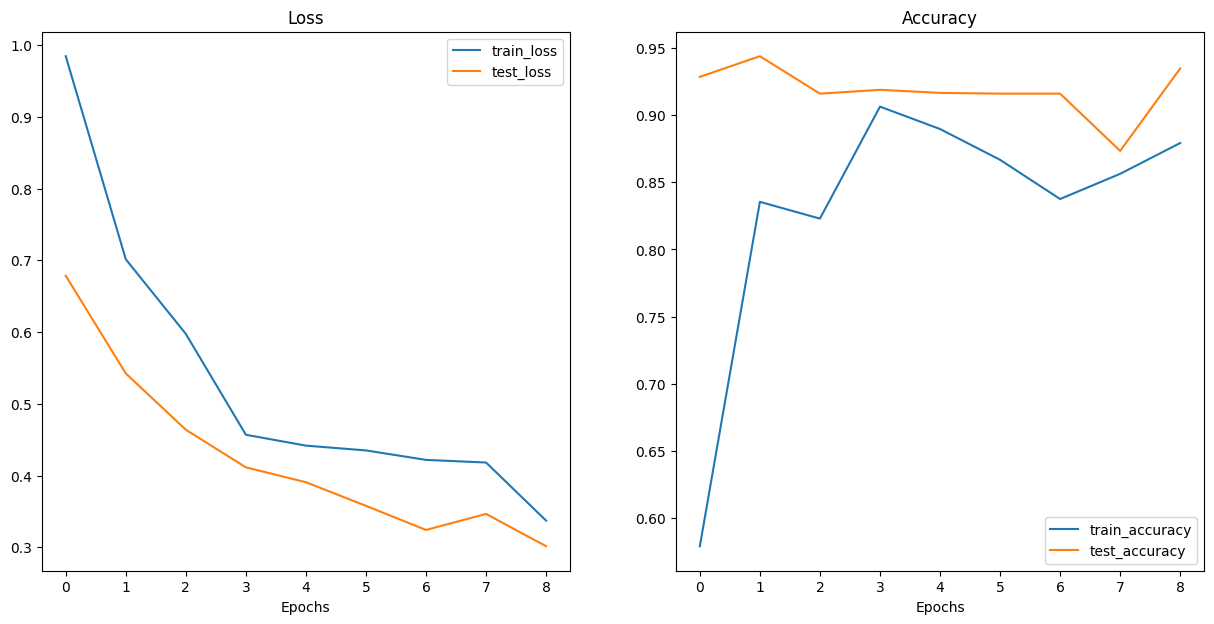

In [20]:
helper_functions.plot_loss_curves(results)

Those loss curves are exactly what we want them to be. The loss going down down down on the train and test sets while the accuracy goes up up up for both as well! 

That's the power of *transfer learning*. You get good results for your problem leveraging the power and the effort that others have already done. Standing on the shoulders of giants and that's a good thing because for some, they just don't have the necessary resources that the people who trained these models had access to.

**Making Predictions From Test Set**

We've seen that the model performs great quantitatively but let's make sure that it also performs great qualitatively. We can do that just by making predictions with it from the test set and then plotting them.

It's always great to see the model do work with live images and then visualize how it does these. 

Remember, that we need the images to be transformed to be compatible with what the model was trained on. This means that we have to do make sure of the following consistencies:

* Same Shape
* Same Datatype
* Same Device
* Same Transforms

So let's make the function that can do all that. We'll call this function *pred_and_plot_image()* which will do the ofllowing:

1. Take in a trained model, list of class names, a filepath to the target image, image size, transform, and device.
2. Open image with *PIL.Image.open()*
3. Create the necessary transform for the image - this will default to the one that we manually created earlier -> *manual_transform* or be automated with *weights.transfroms()*
4. Ensure that the model is on the target device.
5. Turn on *model.eval()* so that layers such as *nn.Dropout()* in the classifier would be turned off because we aren't training anymore.
6. Transform the target image with the transform in step 3 and add an extra batch dimension with *torch.unsqueeze(dim=0)* so that we can achieve [batch_size, color_channels, height, width].
7. Make prediction on the image by sending it through the model and also making sure that the image is on the same device
8. Convert the model logits into prediction probabilities with *torch.softmax(dim=1)*
9. Convert the prediction probabilities into prediction labels with *torch.argmax(dim=1)*
10. Plot the image with *matplotlib* and set the title to the prediction label and prediction probability. 

In [37]:
def pred_plot_image(
    model: torch.nn.Module,
    class_list: List[str],
    target_image: str,
    image_size: Tuple[int,int] = (224,224),
    transform: torchvision.transforms = None,
    device: torch.device = device
):
    image = Image.open(target_image)
    if transform:
        transformed_image = transform(image)
    else: 
        transformed_image = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                std=[0.229,0.224,0.225])
        ])

    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = transformed_image.unsqueeze(dim=0).to(device)
        logits = model(transformed_image)
        
    probabilities = torch.softmax(logits, dim=1)
    labels = torch.argmax(probabilities, dim=1)

    plt.figure()
    plt.imshow(image)
    plt.title(f"Pred: {class_list[labels.item()]} | Prob: {probabilities.max():.3f}")
    plt.axis()

That's a function that meets everything that we need. Let's test it out by making some predictions on a few random images from the test set.

Let's grab all the images from the test set by putting them into a list with all the test image paths with *list(Path(test_dir).glob("asterisk/asterisk.jpg"))*. Remember that the asterisks in the *glob* function indicates that it will match anything that matches the pattern so basically, we're saying that it will grab everything that is a *.jpg* which is all of our images.

Then since we have all the paths for each of the images in the test set, we'll just randomly select one of them with Python's *random.sample(population, k)* method. *population* is the sequence of the sample and *k* is the number of samples that we'll be taking. 

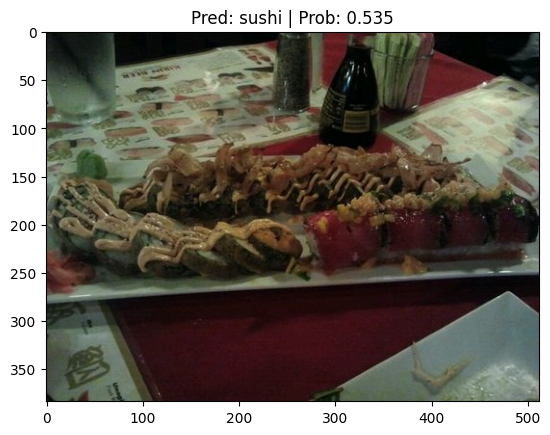

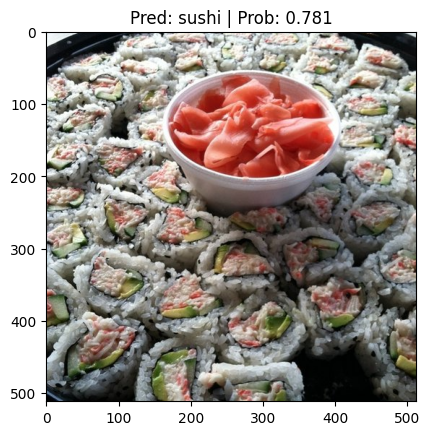

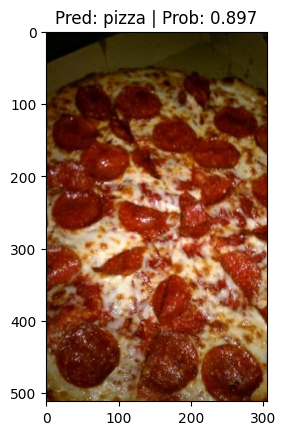

In [38]:
num_plot_img = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list, k=num_plot_img)

for image_path in test_image_path_sample:
    pred_plot_image(model=model,
                   class_list=class_list,
                   target_image=image_path,
                   image_size=(224,224),
                   transform=auto_transforms,
                   device=device)

Looks like the model is predicting pretty well! Certainly better than the results from TinyVGG

**Making Predictions With Custom Image**

The model is performing good with the data on the test set and while that's already a good indicator, it's still better to try sending in an input that is not from the train or test dataset. Let's try sending in a custom image that we want. 

It could be any image that you want! That's the beauty of machine learning after all. 

So go ahead and try sending in a custom image that you want and see what the output is. You can still use the same function earlier - *pred_plot_image()*.

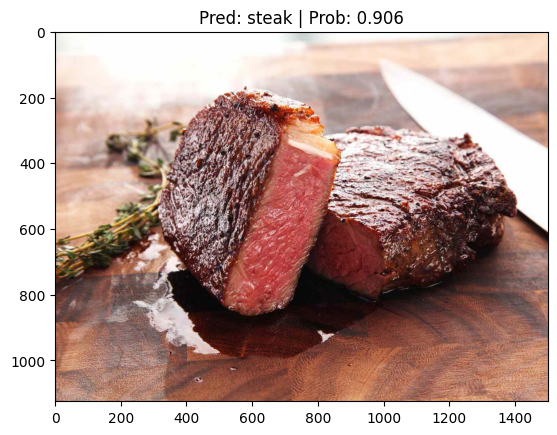

In [42]:
custom_image_data = Path('custom')
custom_image_path = custom_image_data/'image.jpg'

pred_plot_image(model=model,
               class_list=class_list,
               target_image=custom_image_path,
               image_size=(224,224),
               transform=auto_transforms,
               device=device)

Now that's a confident model! The power of transfer learning really makes everything easier and fun. Having a model that predicts something correctly is just pure satisfaction. Just comes to show that *efficientnet_b0* is much more confident in predicting compared to *TinyVGG*. 

**Main Takeaways**

* **Transfer learning** leverages the work that experts have done before and will result in good prediction power even with a small custom dataset

* It's always best to ask the question before creating models from scratch - is there already an existing model that covers my problem?

* When it comes to using custom models, it's important to make sure that the data is preprocessed and transformed to the same characteristics (shape) that the model's training data was based on.

* The same can be said for custom data that you want to predict on.

* There are many different places to grab custom pretrained models such as PyTorch domain libraries, HuggingFace Hub, and TIMM - PyTorch Image Models.

**Exercises**